In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import math
import itertools
import matplotlib.pyplot as plt
import tensorflow_probability.python.experimental.substrates.jax as tfp
from IMNN.experimental.jax.imnn import SimulatorIMNN
from IMNN.experimental.jax.lfi import GaussianApproximation
from IMNN.experimental.jax.lfi import ApproximateBayesianComputation
rng = jax.random.PRNGKey(0)

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Simulator in JAX

In [3]:
θ_fid = np.array([0., 1.])
n_params = 2
input_shape = (10,)
simulator_args = {"input shape": input_shape}

In [4]:
def simulator(rng, θ, simulator_args=simulator_args):
    μ, Σ = θ
    def fn(key, μ, Σ):
        return μ + np.sqrt(Σ) * jax.random.normal(key, shape=simulator_args["input shape"])
    if μ.shape == Σ.shape:
        if len(μ.shape) == 0:
            return fn(rng, μ, Σ)
        else:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ, Σ)
    else:
        if len(μ.shape) > 0:
            keys = jax.random.split(rng, num=μ.shape[0]+1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(lambda key, μ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, μ)
        elif len(Σ.shape) > 0:
            keys = jax.random.split(rng, num=Σ.shape[0])
            return jax.vmap(lambda key, Σ : simulator(key, (μ, Σ), simulator_args=simulator_args))(keys, Σ)

In [5]:
μs = [np.zeros(()), np.zeros((1,)), np.zeros((2,)), np.zeros((1, 1)), np.zeros((1, 2)), np.zeros((2, 1)), np.zeros((2, 2)), np.zeros((1, 2, 3)), np.zeros((2, 1, 3)), np.zeros((3, 2, 1))] 
Σs = [np.ones(()), np.ones((1,)), np.ones((2,)), np.ones((1, 1)), np.ones((1, 2)), np.ones((2, 1)), np.ones((2, 2)), np.ones((1, 2, 3)), np.ones((2, 1, 3)), np.ones((3, 2, 1))]
for θ in itertools.product(μs[:2], Σs[:2]):
    simulation = simulator(rng, θ, simulator_args=simulator_args)
    print(θ[0].shape, θ[1].shape, simulation.shape)

() () (10,)
() (1,) (1, 10)
(1,) () (1, 10)
(1,) (1,) (1, 10)


# Data for ABC example

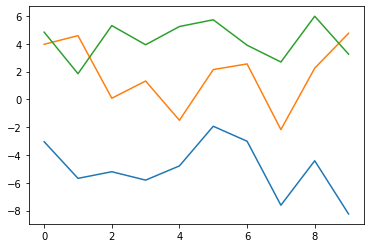

In [6]:
rng, key = jax.random.split(rng)
target_data = simulator(key, (np.array([-5., 2., 4.]), np.array([2., 5., 1.])), simulator_args=simulator_args)
plt.plot(target_data.T);

In [7]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]
        
    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = jax.random.split(key, num=len(self.event_shape))
        return [jax.random.uniform(keys[i], shape=(n,), minval=self.low[i], maxval=self.high[i]) for i in range(len(self.event_shape))]
    
#prior = tfp.distributions.JointDistributionSequential([
#    tfp.distributions.Uniform(-10., 10.),
#    tfp.distributions.Uniform(0., 10.)])
#prior.low = [-10., 0.]
#prior.high = [10., 10.]
prior = uniform([-10., 0.], [10., 10.])

# Model in STAX

In [8]:
n_summaries = 5
n_s = 1000
n_d = 1000
λ = 10.
ϵ = 0.01
α = - math.log(ϵ * (λ - 1.) + ϵ**2. / (1 + ϵ)) / ϵ

In [9]:
model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries))

In [10]:
optimiser = optimizers.adam(step_size=1e-3)

# Random seeds for IMNN

In [11]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

# Simulations on the fly

### Initialise IMNN

In [12]:
imnn = SimulatorIMNN(n_s=n_s, n_d=n_d, n_summaries=n_summaries, input_shape=input_shape, 
                     θ_fid=θ_fid, key=initial_model_key, model=model, optimiser=optimiser, 
                     simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args))

#### Fit

In [13]:
imnn.fit(λ=λ, α=α, rng=fitting_key)

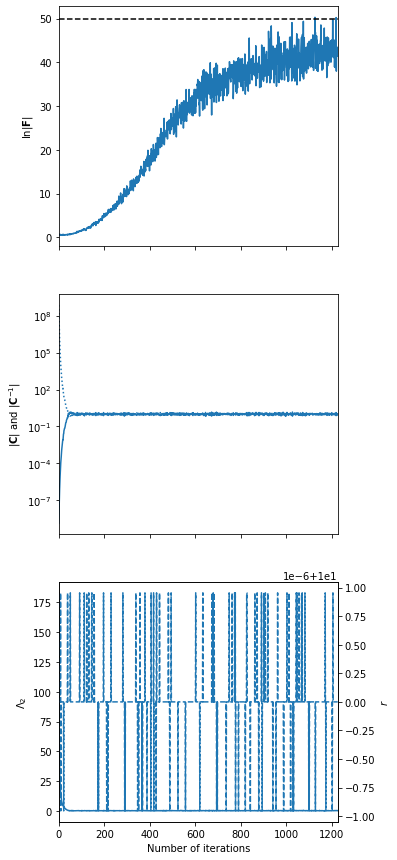

In [14]:
imnn.training_plot(expected_detF=50);

#### ABC

In [15]:
target_summaries = imnn.get_estimate(target_data)

In [16]:
GA = GaussianApproximation(target_summaries, imnn.invC, prior)

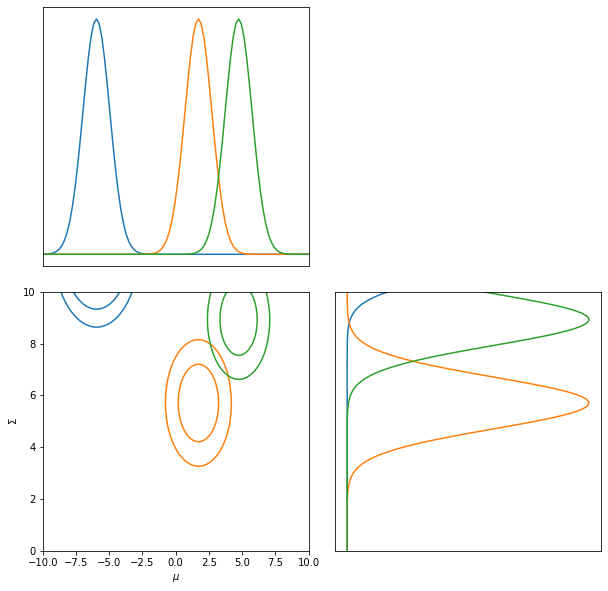

In [17]:
GA.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"]);

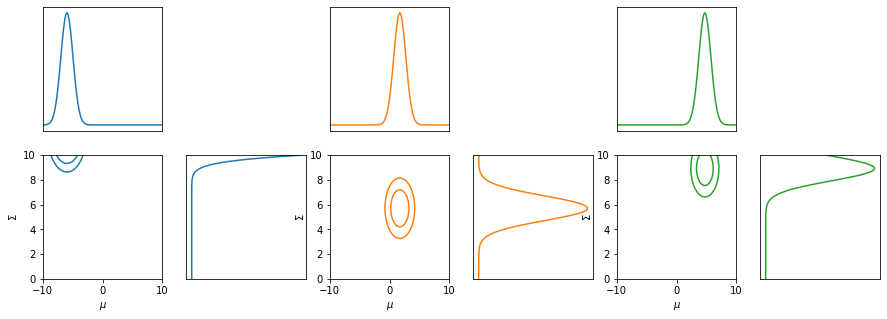

In [18]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
GA.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
GA.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
GA.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);

In [34]:
ABC = ApproximateBayesianComputation(target_data, prior, simulator, imnn.get_estimate, F=imnn.F, gridsize=50)

In [38]:
rng, key = jax.random.split(rng)
ABC(rng=key, n_samples=int(1e6), min_accepted=1000, max_iterations=1000, ϵ=0.1, smoothing=1);

0 accepted in last 0 iterations  (0 simulations done). 


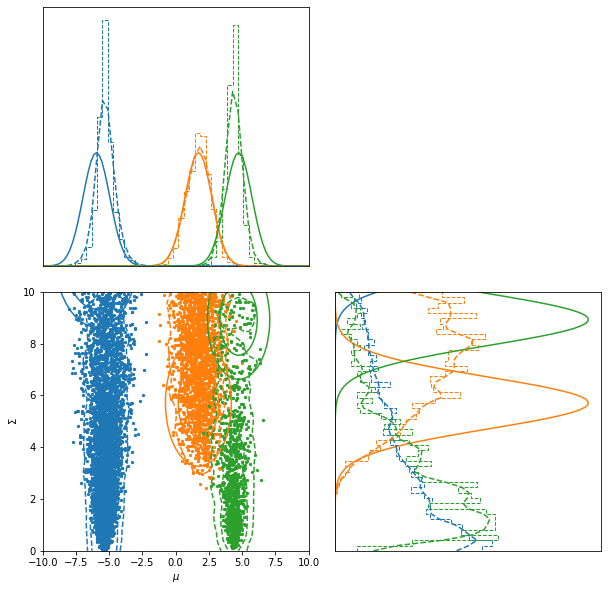

In [39]:
ax = GA.marginal_plot(labels=[r"$\mu$", r"$\Sigma$"])
ABC.marginal_plot(ax=ax, linestyle="dashed")
ABC.scatter_plot(ax=ax, linestyle="dashed");

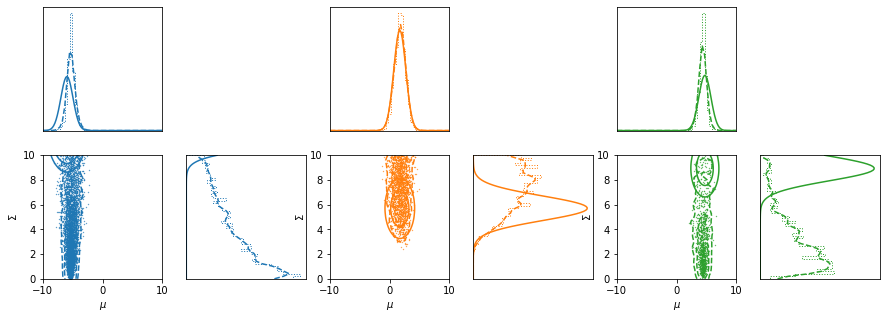

In [43]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
GA.marginal_plot(ax=ax[:, :2], labels=[r"$\mu$", r"$\Sigma$"], target=0, format=True);
ABC.marginal_plot(ax=ax[:, :2], linestyle="dashed", target=0);
ABC.scatter_plot(ax=ax[:, :2], linestyle="dotted", target=0, s=0.1);
GA.marginal_plot(ax=ax[:, 2:4], labels=[r"$\mu$", r"$\Sigma$"], target=1, format=True);
ABC.marginal_plot(ax=ax[:, 2:4], linestyle="dashed", target=1);
ABC.scatter_plot(ax=ax[:, 2:4], linestyle="dotted", target=1, s=0.1);
GA.marginal_plot(ax=ax[:, 4:], labels=[r"$\mu$", r"$\Sigma$"], target=2, format=True);
ABC.marginal_plot(ax=ax[:, 4:], linestyle="dashed", target=2);
ABC.scatter_plot(ax=ax[:, 4:], linestyle="dotted", target=2, s=0.1);

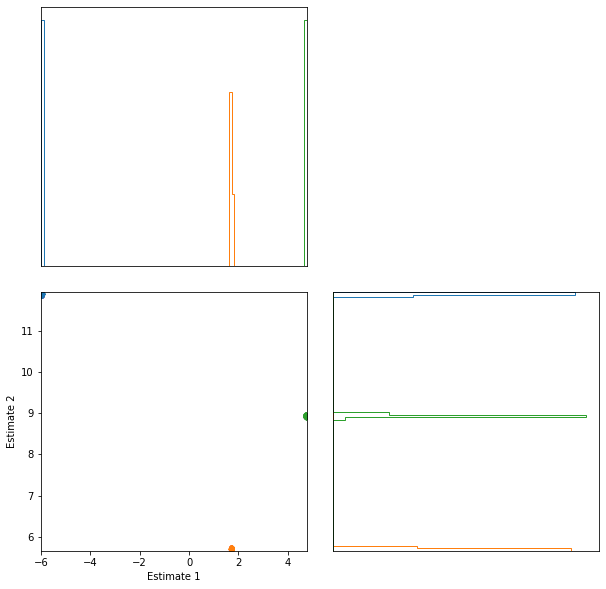

In [41]:
ABC.scatter_summaries(labels=["Estimate 1", "Estimate 2"]);

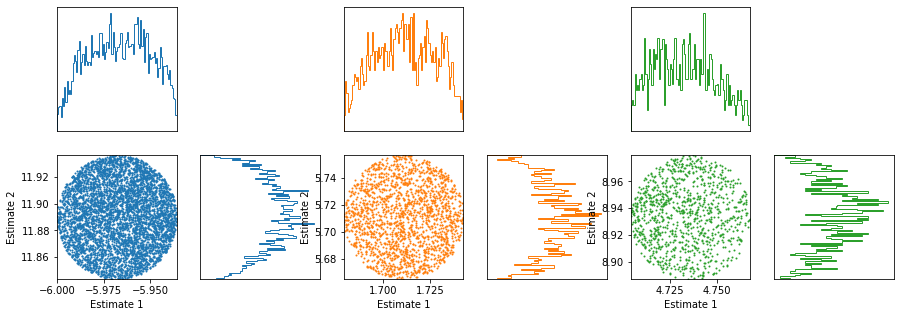

In [42]:
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
ABC.scatter_summaries(ax=ax[:, :2], labels=["Estimate 1", "Estimate 2"], s=1, target=0, format=True);
ABC.scatter_summaries(ax=ax[:, 2:4], labels=["Estimate 1", "Estimate 2"], s=1, target=1, format=True);
ABC.scatter_summaries(ax=ax[:, 4:], labels=["Estimate 1", "Estimate 2"], s=1, target=2, format=True);